In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [3]:
#read transactions data
transactions = pd.read_csv('transactions_obf.csv')
transactions.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500


In [4]:
#read fraud labels
labels = pd.read_csv('labels_obf.csv')
labels.head()

,reportedTime,eventId
0,2017-01-04T00:00:00Z,101536329A1
1,2017-01-04T00:00:00Z,101536425A1
2,2017-01-04T00:00:00Z,101536473A1
3,2017-01-04T00:00:00Z,101536617A1
4,2017-01-04T00:00:00Z,101536761A1


In [5]:
#add a fraud column to the transaction data and compare it with labels data frame to match the eventiD and classify it as fraud or not
transactions['fraud'] = transactions['eventId'].isin(labels['eventId'])
#convert the fraud column to int
transactions['fraud'] = transactions['fraud'].astype(int)
transactions.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,fraud
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0


In [6]:
transactions.describe()

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraud
count,118621.000000,118621.000000,118621.000000,118621.000000,118621.000000,118621.000000
mean,5834.407272,759.124388,28.552651,53.674774,6625.508974,0.007376
std,976.183515,154.070084,35.647616,183.665315,3410.289486,0.085569
min,742.000000,31.000000,0.000000,-0.150000,500.000000,0.000000
25%,5411.000000,826.000000,5.000000,8.030000,4500.000000,0.000000
50%,5691.000000,826.000000,5.000000,20.250000,7500.000000,0.000000
75%,5967.000000,826.000000,81.000000,49.000000,8500.000000,0.000000
max,9405.000000,840.000000,91.000000,13348.000000,18500.000000,1.000000


In [7]:
transactions.groupby('fraud').count()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
fraud,,,,,,,,,,
0,117746,117746,117746,117746,117746,117746,95302,117746,117746,117746
1,875,875,875,875,875,875,314,875,875,875


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transactionTime    118621 non-null  object 
 1   eventId            118621 non-null  object 
 2   accountNumber      118621 non-null  object 
 3   merchantId         118621 non-null  object 
 4   mcc                118621 non-null  int64  
 5   merchantCountry    118621 non-null  int64  
 6   merchantZip        95616 non-null   object 
 7   posEntryMode       118621 non-null  int64  
 8   transactionAmount  118621 non-null  float64
 9   availableCash      118621 non-null  int64  
 10  fraud              118621 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 10.0+ MB


In [9]:
#looking for missing values
transactions.isnull().sum().sort_values()

transactionTime          0
eventId                  0
accountNumber            0
merchantId               0
mcc                      0
merchantCountry          0
posEntryMode             0
transactionAmount        0
availableCash            0
fraud                    0
merchantZip          23005
dtype: int64

In [10]:
#since merchantZip has a lot of missing values and not useful for analysis, we can drop it
transactions.drop(['merchantZip'], axis=1, inplace=True)
transactions.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraud
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,1,10.72,7500,0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,81,21.19,4500,0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,81,5.04,9500,0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,81,21.00,7500,0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,81,47.00,10500,0


In [11]:
#converting transactionTime to datetime
transactions['transactionTime'] = pd.to_datetime(transactions['transactionTime'])
transactions.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraud
0,2017-01-01 00:00:00+00:00,18688431A1,94f9b4e7,b76d06,5968,826,1,10.72,7500,0
1,2017-01-01 00:49:03+00:00,2164986A1,648e19cf,718cc6,5499,826,81,21.19,4500,0
2,2017-01-01 00:43:17+00:00,31294145A1,c0ffab1b,94cafc,5735,442,81,5.04,9500,0
3,2017-01-01 00:15:07+00:00,11162049A1,038099dd,7d5803,5499,826,81,21.00,7500,0
4,2017-01-01 00:37:09+00:00,17067235A1,3130363b,12ca76,5411,826,81,47.00,10500,0


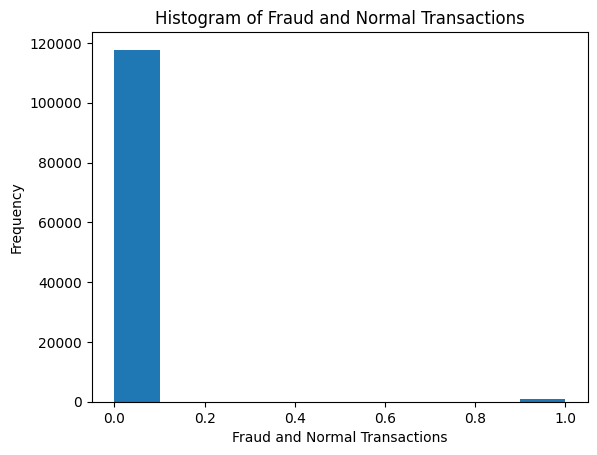

In [12]:
#histogram of fraud and normal transactions
plt.hist(transactions['fraud'])
plt.title('Histogram of Fraud and Normal Transactions')
plt.xlabel('Fraud and Normal Transactions')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Average transaction amount for each available cash amount')

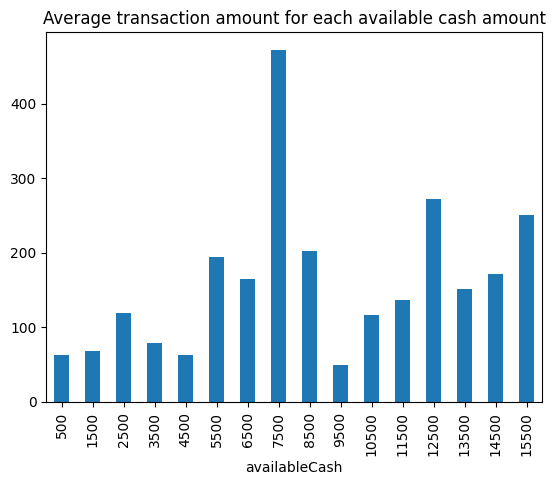

In [77]:
# Filter transactions with fraud == 1 and plot the average transaction amount for each available cash amount
fraudulent_transactions = transactions[transactions['fraud'] == 1]
fraudulent_transactions['transactionAmount'].groupby(fraudulent_transactions['availableCash']).mean().plot(kind='bar')
plt.title('Average transaction amount for each available cash amount')

<AxesSubplot: title={'center': 'Number of fraudulent transactions by merchant ID'}, ylabel='merchantId'>

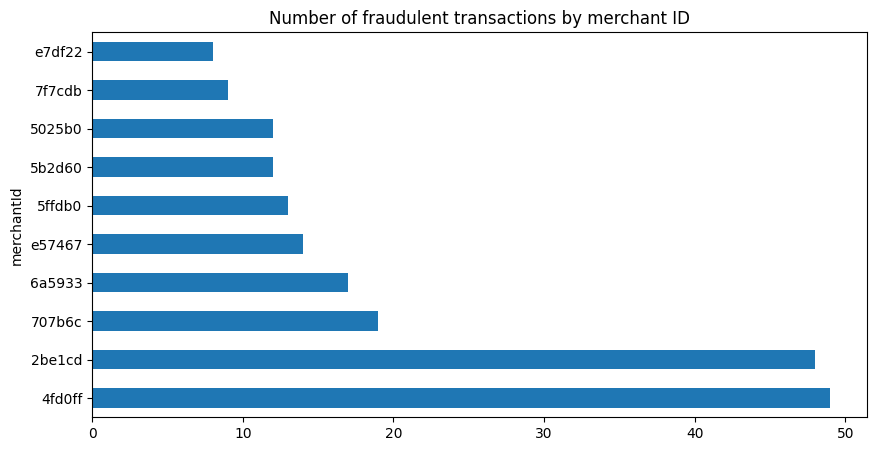

In [14]:
# Filter only the fraudulent transactions and then group by merchantId and count
fraud_transactions = transactions[transactions['fraud'] == 1].groupby('merchantId').size()

# Plot the top 10 merchants with the highest count of fraudulent transactions
fraud_transactions.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10,5), title='Number of fraudulent transactions by merchant ID')


<AxesSubplot: xlabel='transactionAmount'>

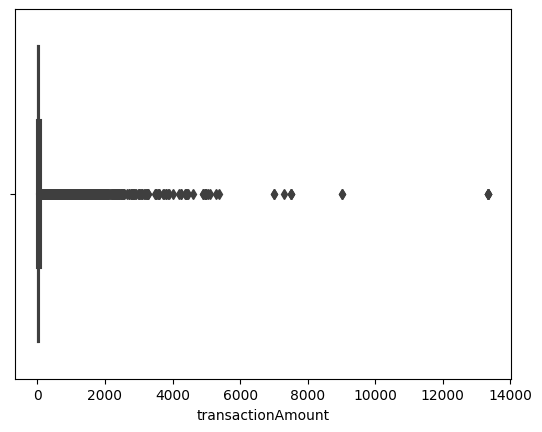

In [15]:
#check for any outliers in the data
sns.boxplot(x=transactions['transactionAmount'])

In [16]:
transactions.columns

Index(['transactionTime', 'eventId', 'accountNumber', 'merchantId', 'mcc',
       'merchantCountry', 'posEntryMode', 'transactionAmount', 'availableCash',
       'fraud'],
      dtype='object')

<AxesSubplot: title={'center': 'Number of fraudulent transactions by Account Number'}, xlabel='accountNumber'>

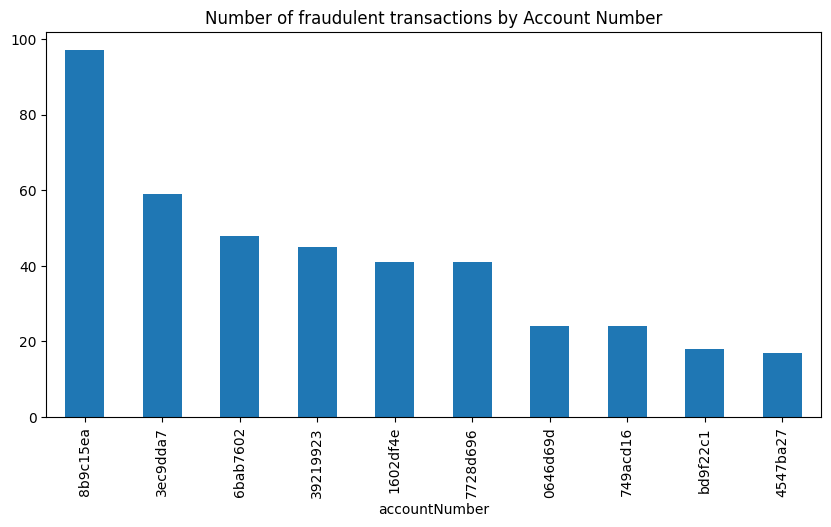

In [17]:
# Filter only the fraudulent transactions and then group by accountNumber and count
fraud_transactions = transactions[transactions['fraud'] == 1].groupby('accountNumber').size()

# Plot the top 10 accounts with the highest count of fraudulent transactions
fraud_transactions.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10,5), title='Number of fraudulent transactions by Account Number')

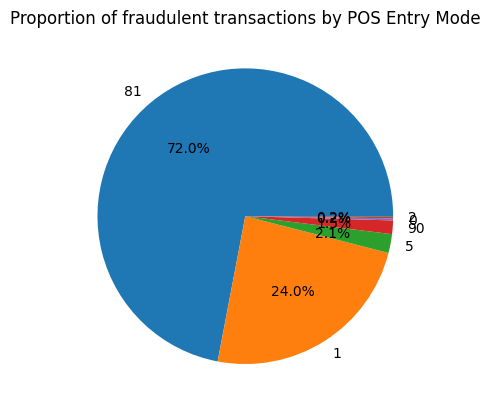

In [18]:
# Filter only the fraudulent transactions and then group by posEntryMode and count
fraud_transactions = transactions[transactions['fraud'] == 1].groupby('posEntryMode').size()

# Select the top 10 POS Entry Modes with the highest count of fraudulent transactions
top_fraud_posEntryModes = fraud_transactions.nlargest(10)

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(top_fraud_posEntryModes, labels = top_fraud_posEntryModes.index, autopct='%1.1f%%')
plt.title('Proportion of fraudulent transactions by POS Entry Mode')
plt.show()


Looks like POS 81 entry style has the most fradulent transactions

In [19]:
#modify the TransactionTime column to extract the day of the week and the hour of the day
transactions['DayOfWeek'] = transactions['transactionTime'].dt.day_name()
transactions['HourOfDay'] = transactions['transactionTime'].dt.hour

<AxesSubplot: title={'center': 'Fraud Transactions by Day of Week'}, xlabel='DayOfWeek'>

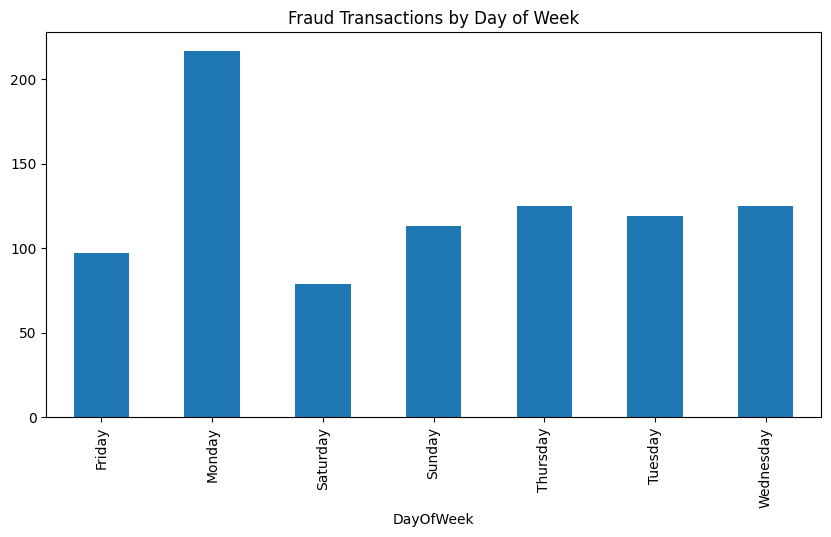

In [20]:
#check if transaction fraud is higher any specific day of the week
fraud_transactions = transactions[transactions['fraud'] == 1].groupby('DayOfWeek')['fraud'].count()
fraud_transactions.plot(kind='bar', figsize=(10,5), title='Fraud Transactions by Day of Week')

<AxesSubplot: title={'center': 'Fraud Transactions by Hour of Day'}, xlabel='HourOfDay'>

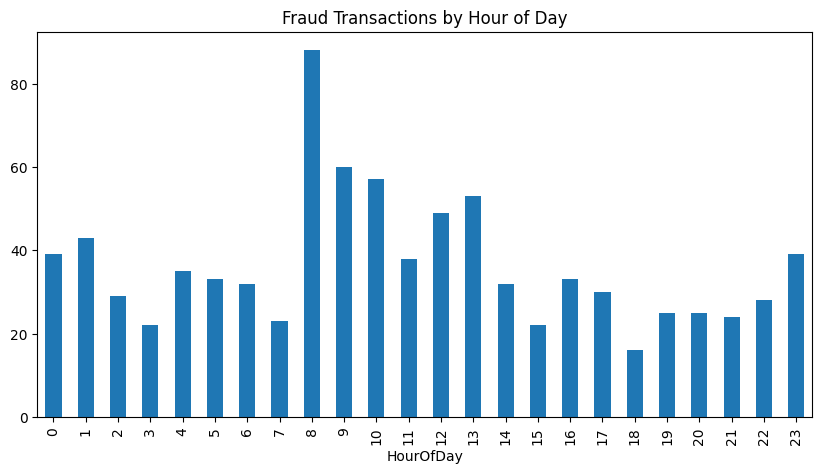

In [21]:
#check if transaction fraud is higher any specific time of the day
fraud_transactions = transactions[transactions['fraud'] == 1].groupby('HourOfDay')['fraud'].count()
fraud_transactions.plot(kind='bar', figsize=(10,5), title='Fraud Transactions by Hour of Day')

In [22]:
transactions.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraud,DayOfWeek,HourOfDay
0,2017-01-01 00:00:00+00:00,18688431A1,94f9b4e7,b76d06,5968,826,1,10.72,7500,0,Sunday,0
1,2017-01-01 00:49:03+00:00,2164986A1,648e19cf,718cc6,5499,826,81,21.19,4500,0,Sunday,0
2,2017-01-01 00:43:17+00:00,31294145A1,c0ffab1b,94cafc,5735,442,81,5.04,9500,0,Sunday,0
3,2017-01-01 00:15:07+00:00,11162049A1,038099dd,7d5803,5499,826,81,21.00,7500,0,Sunday,0
4,2017-01-01 00:37:09+00:00,17067235A1,3130363b,12ca76,5411,826,81,47.00,10500,0,Sunday,0


In [23]:
#dropping eventID and traactionTime since we have fraud as a unique identifier for each event
transactions = transactions.drop(['eventId','transactionTime'], axis=1)

In [24]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   accountNumber      118621 non-null  object 
 1   merchantId         118621 non-null  object 
 2   mcc                118621 non-null  int64  
 3   merchantCountry    118621 non-null  int64  
 4   posEntryMode       118621 non-null  int64  
 5   transactionAmount  118621 non-null  float64
 6   availableCash      118621 non-null  int64  
 7   fraud              118621 non-null  int64  
 8   DayOfWeek          118621 non-null  object 
 9   HourOfDay          118621 non-null  int32  
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 8.6+ MB


In [25]:
#Need to change the label encoding for the categorical variables to numerical variables for accountNumber, MerchantID, DayOfWeek
le = LabelEncoder()
transactions['accountNumber'] = le.fit_transform(transactions['accountNumber'])
transactions['merchantId'] = le.fit_transform(transactions['merchantId'])
transactions['DayOfWeek'] = le.fit_transform(transactions['DayOfWeek'])
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   accountNumber      118621 non-null  int64  
 1   merchantId         118621 non-null  int64  
 2   mcc                118621 non-null  int64  
 3   merchantCountry    118621 non-null  int64  
 4   posEntryMode       118621 non-null  int64  
 5   transactionAmount  118621 non-null  float64
 6   availableCash      118621 non-null  int64  
 7   fraud              118621 non-null  int64  
 8   DayOfWeek          118621 non-null  int64  
 9   HourOfDay          118621 non-null  int32  
dtypes: float64(1), int32(1), int64(8)
memory usage: 8.6 MB


In [26]:
#Getting the correlation between the columns
transactions.corr()

,accountNumber,merchantId,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,fraud,DayOfWeek,HourOfDay
accountNumber,1.000000,0.005178,-0.001261,-0.019770,0.017785,0.002989,-0.073073,-0.010778,-0.002611,-0.000314
merchantId,0.005178,1.000000,0.006058,0.064624,-0.049161,0.001765,0.010619,-0.005862,-0.004996,-0.002899
mcc,-0.001261,0.006058,1.000000,-0.092775,0.174846,-0.011087,-0.076448,0.007664,-0.010560,-0.003143
merchantCountry,-0.019770,0.064624,-0.092775,1.000000,-0.518626,0.030868,0.068169,-0.047684,0.004163,0.016630
posEntryMode,0.017785,-0.049161,0.174846,-0.518626,1.000000,-0.007927,-0.086346,0.076059,-0.020679,-0.013425
transactionAmount,0.002989,0.001765,-0.011087,0.030868,-0.007927,1.000000,0.063817,0.028863,-0.005276,0.005696
availableCash,-0.073073,0.010619,-0.076448,0.068169,-0.086346,0.063817,1.000000,-0.051822,-0.009892,0.004798
fraud,-0.010778,-0.005862,0.007664,-0.047684,0.076059,0.028863,-0.051822,1.000000,-0.002742,-0.015770
DayOfWeek,-0.002611,-0.004996,-0.010560,0.004163,-0.020679,-0.005276,-0.009892,-0.002742,1.000000,0.002420
HourOfDay,-0.000314,-0.002899,-0.003143,0.016630,-0.013425,0.005696,0.004798,-0.015770,0.002420,1.000000


<AxesSubplot: >

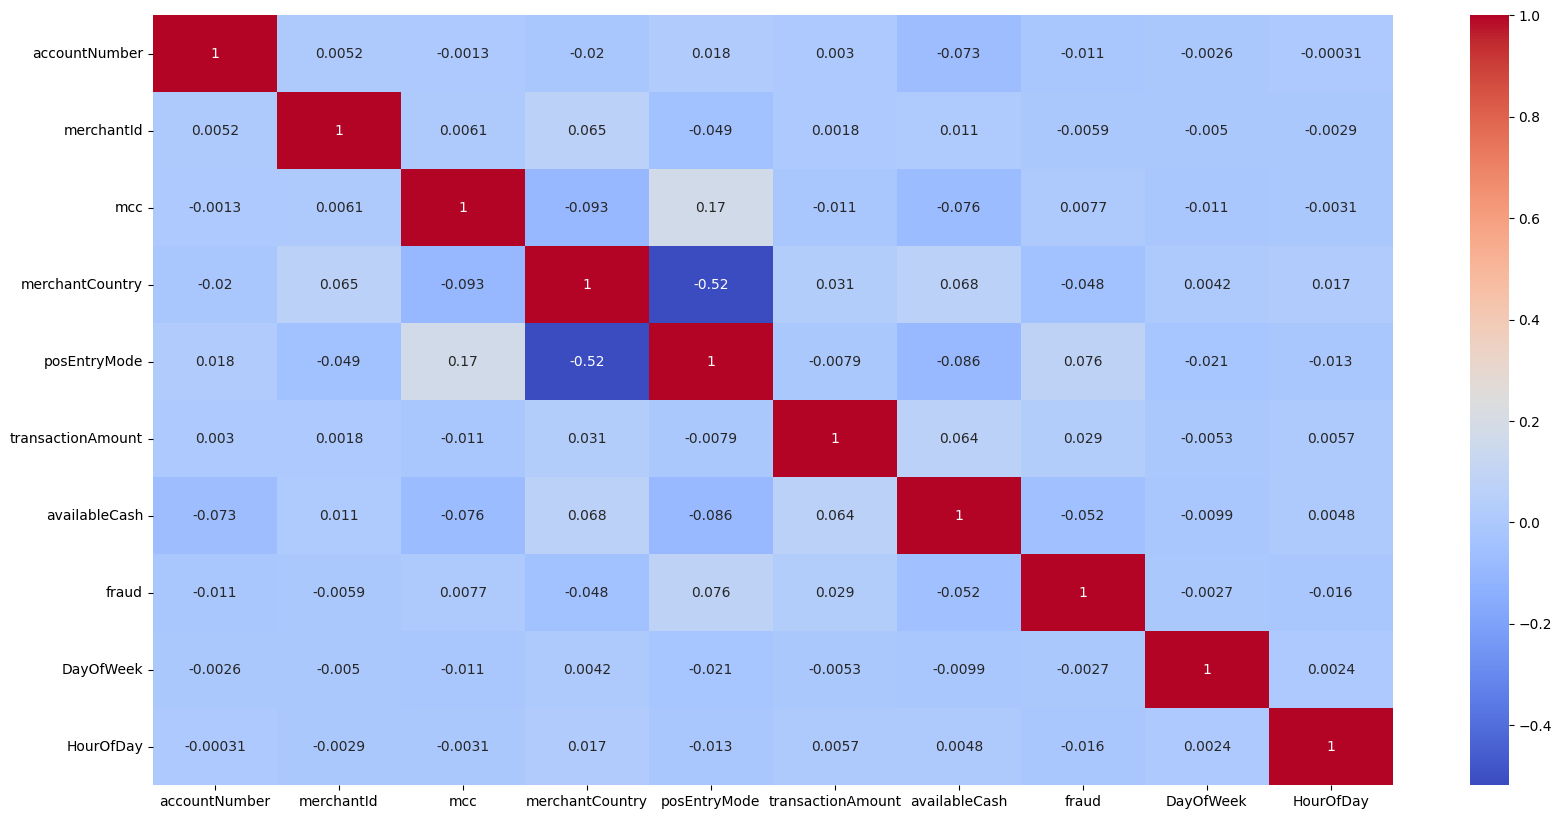

In [27]:
#creating a heatmap to see the correlation between the features spearman method
plt.figure(figsize=(20,10))
sns.heatmap(transactions.corr(), annot=True, cmap='coolwarm')

/Users/abhishekshah/opt/anaconda3/envs/tensor/lib/python3.8/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


<AxesSubplot: >

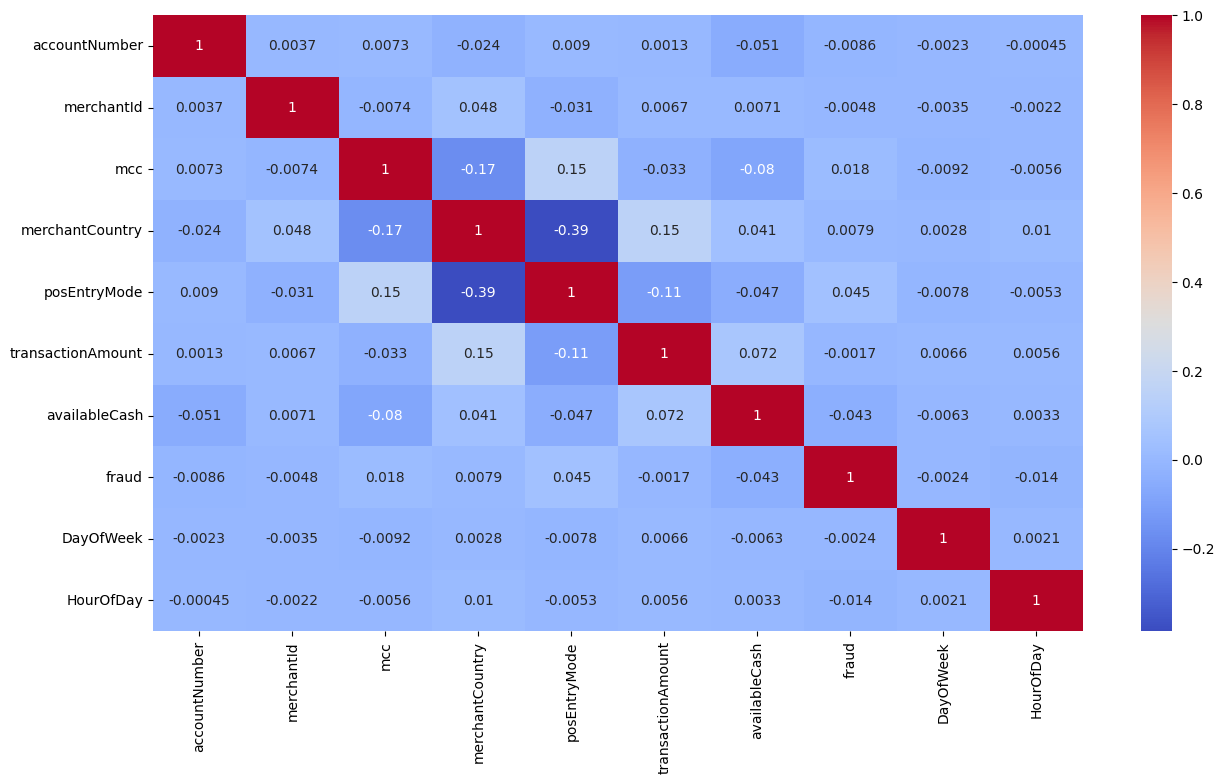

In [28]:
#trying corelation matrix for kendal to see if there is any non-linear corelation between the variables
transactions.corr(method='kendall')

#plotting the corelation matrix
plt.figure(figsize=(15,8))
sns.heatmap(transactions.corr(method='kendall'), annot=True, cmap='coolwarm')

In [29]:
#split the data into X(features) and y(target)
X = transactions.drop('fraud', axis=1).values
y = transactions['fraud'].values

In [30]:
#scaling the data to bring all the features to the same level of magnitude
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
#splitting the data into training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state = 42)

In [32]:
#Creating a KNN model to predict fraud
knn = KNeighborsClassifier(n_neighbors=5)
#fit the classifier to the data
knn.fit(X_train,y_train)
#predict the response
y_pred = knn.predict(X_test)
#Getting the accuracy of the model
knn.score(X_test,y_test)

0.9927502634351949

In [33]:
# Creating neighbors and accuracies lists for neighbors between 1 and 13
neighbors = np.arange(1, 13)
train_accuracies = {}
test_accuracies = {}

for neighbor in neighbors:
  
	# Setting up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
  
	# Fitting the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)

[ 1  2  3  4  5  6  7  8  9 10 11 12] 
 {1: 1.0, 2: 0.9965857359635811, 3: 0.9959850784016187, 4: 0.9949102175012645, 5: 0.9946573090541224, 6: 0.9942990220873377, 7: 0.9941725678637666, 8: 0.9938353566009105, 9: 0.9938669701568033, 10: 0.9934349182262687, 11: 0.9934138425223402, 12: 0.9933716911144832} 
 {1: 0.9927081138040043, 2: 0.993972602739726, 3: 0.993508956796628, 4: 0.9933403582718652, 5: 0.9927502634351949, 6: 0.9931296101159115, 7: 0.99304531085353, 8: 0.9931296101159115, 9: 0.9931296101159115, 10: 0.9928767123287672, 11: 0.9929610115911486, 12: 0.9930874604847207}


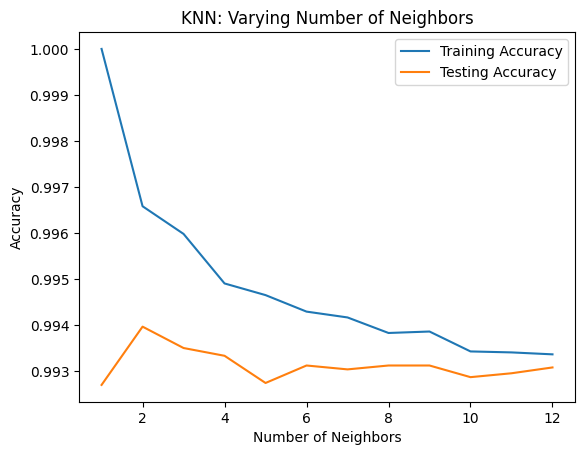

In [34]:
#visualizing model complexity
plt.title("KNN: Varying Number of Neighbors")

# Plotting training accuracies
plt.plot( neighbors,train_accuracies.values(), label="Training Accuracy")

# Plotting test accuracies
plt.plot( neighbors,test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()

In [35]:
#based on this model, looks like the best neighbors is 8
#Creating a KNN model to predict fraud
knn = KNeighborsClassifier(n_neighbors=8)
#fitting the classifier to the data
knn.fit(X_train,y_train)
#predicting the response
y_pred = knn.predict(X_test)
#Getting the accuracy of the model
knn.score(X_test,y_test)

0.9931296101159115

In [36]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Generate the confusion matrix and classification report and roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5906966684432909
[[23528    10]
 [  153    34]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23538
           1       0.77      0.18      0.29       187

    accuracy                           0.99     23725
   macro avg       0.88      0.59      0.65     23725
weighted avg       0.99      0.99      0.99     23725



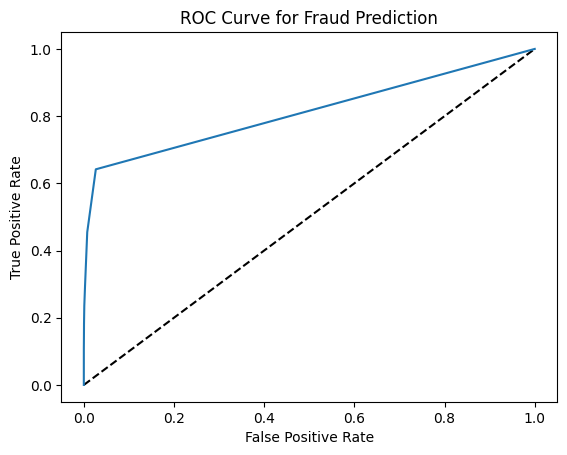

In [37]:
# Predict probabilities
y_pred_probs = knn.predict_proba(X_test)[:,1]

# Import roc_curve
from sklearn.metrics import roc_curve

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Prediction')
plt.show()

This Curve doesn't look very good. We will try Logistic Regression and see that improves

In [38]:
#let's try logistic regression
from sklearn.linear_model import LogisticRegression

# Create an instance of the model
logreg = LogisticRegression()

# Fit the model
logreg.fit(X_train,y_train)

# Predict probabilities
y_pred_probs = logreg.predict_proba(X_test)[:,1]
print(y_pred_probs[:10])


[0.00235841 0.00138482 0.00329591 0.02897742 0.00374607 0.00178525
 0.00426661 0.00205547 0.00121276 0.00120376]


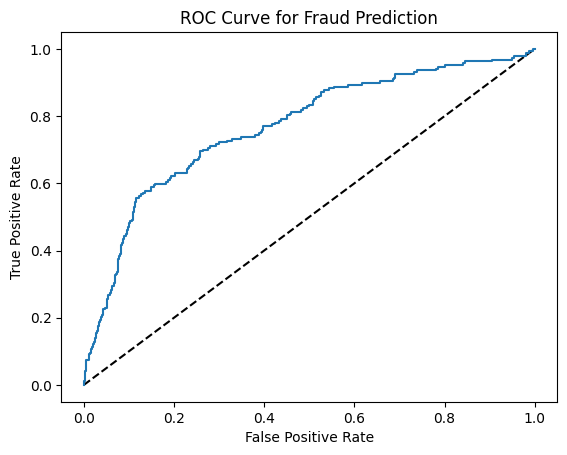

In [39]:
# Import roc_curve
from sklearn.metrics import roc_curve

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Prediction')
plt.show()

In [40]:
# Calculate roc_auc_score
print(roc_auc_score(y_test, y_pred_probs))

# Calculate the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Calculate the classification report
print(classification_report(y_test, y_pred))

0.7672767621636284
[[23528    10]
 [  153    34]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23538
           1       0.77      0.18      0.29       187

    accuracy                           0.99     23725
   macro avg       0.88      0.59      0.65     23725
weighted avg       0.99      0.99      0.99     23725



In [41]:
#trying cross validation to see if it improves the model
from sklearn.model_selection import KFold, cross_val_score
# Create a KFold object
kf = KFold(n_splits=6, shuffle=True, random_state=5)

reg = LogisticRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print scores
print(cv_scores)

[0.99210966 0.99251391 0.99241275 0.99286798 0.99347496 0.99210926]


In [42]:
# Getting the mean CV score
print(np.mean(cv_scores))

# Getting the std CV score
print(np.std(cv_scores))

# Print the 95% confidence interval
print(np.quantile(cv_scores, [0.025, 0.975]))

0.9925814187349894
0.00047592778063596273
[0.99210931 0.99339909]


In [43]:
#Performing hyperparameter tuning using GridSearchCV
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Set up the parameter grid
params = {"penalty": ["l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}


# Instantiate lasso_cv
logreg_cv = RandomizedSearchCV(logreg, params, cv=kf)

# Fit to the training data
logreg_cv.fit(X_train,y_train)
print("Tuned logreg paramaters: {}".format(logreg_cv.best_params_))
print("Tuned logreg score: {}".format(logreg_cv.best_score_))

Tuned logreg paramaters: {'tol': 0.9387816326530612, 'penalty': 'l2', 'class_weight': {0: 0.8, 1: 0.2}, 'C': 0.6877551020408164}
Tuned logreg score: 0.9927499578485922


In [44]:
#trying the logistic regression model with the hyperparameters found in the grid search

logreg = LogisticRegression(solver='lbfgs', penalty='l2', C=0.15510204081632656, class_weight={0: 0.8, 1: 0.2})

# Fit the model.
logreg.fit(X_train, y_train)

# Predict on the test set.
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


In [45]:
# Generate the confusion matrix and classification report and roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5
[[23538     0]
 [  187     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23538
           1       0.00      0.00      0.00       187

    accuracy                           0.99     23725
   macro avg       0.50      0.50      0.50     23725
weighted avg       0.98      0.99      0.99     23725



/Users/abhishekshah/opt/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abhishekshah/opt/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abhishekshah/opt/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Even after the hyperparameter tuning, this model doesn't yield better results. 

Checking if other models might be better and trying crossvalidation

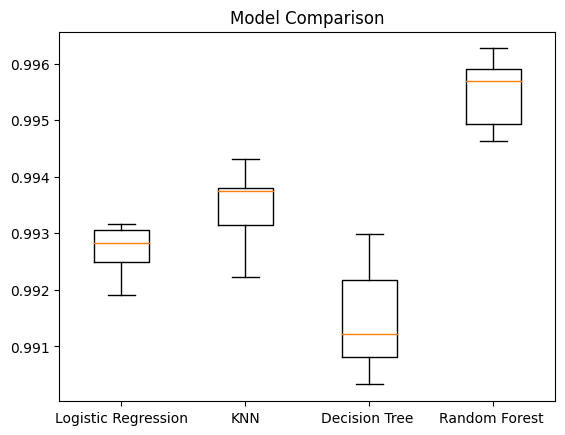

<Figure size 1500x1000 with 0 Axes>

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Create models dictionary
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), "Decision Tree ": DecisionTreeClassifier(), "Random Forest ": RandomForestClassifier()}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train, cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.title("Model Comparison")
plt.figure(figsize=(15,10))
plt.show()

Looks Like might perform better KNN and Random Forest perform better with CrossValidation 

In [47]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

knn = KNeighborsClassifier(n_neighbors=6)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report and roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.609264550257338
[[23521    17]
 [  146    41]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23538
           1       0.71      0.22      0.33       187

    accuracy                           0.99     23725
   macro avg       0.85      0.61      0.67     23725
weighted avg       0.99      0.99      0.99     23725



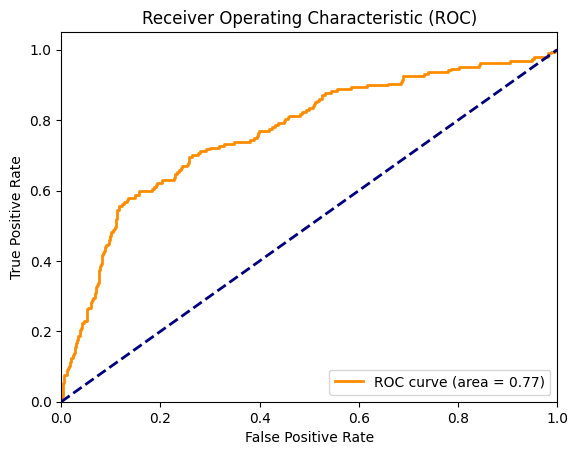

In [48]:
# Import roc_curve
from sklearn.metrics import roc_curve,auc

y_pred_prob = knn.predict_proba(X_test)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Let's see if CrossValidation improves this score

In [49]:
from sklearn.model_selection import cross_val_score

# Create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=6)

# train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)

# print each cv score (accuracy) and average them
print(cv_scores)
print(f'cv_scores mean:{np.mean(cv_scores)}')

[0.99357218 0.99341377 0.99288687 0.99299225 0.99346646]
cv_scores mean:0.9932663093716082


In [50]:
#check to see if the model has improved
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.609264550257338
[[23521    17]
 [  146    41]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23538
           1       0.71      0.22      0.33       187

    accuracy                           0.99     23725
   macro avg       0.85      0.61      0.67     23725
weighted avg       0.99      0.99      0.99     23725



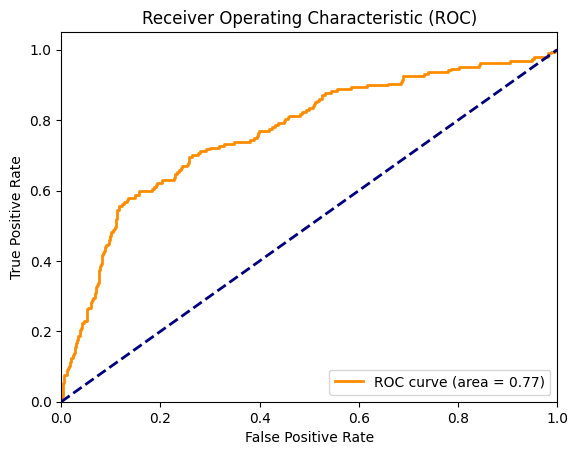

In [51]:
# Import roc_curve
from sklearn.metrics import roc_curve,auc

y_pred_prob = knn_cv.predict_proba(X_test)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [52]:
print(roc_auc_score(y_test, y_pred))
print(auc(fpr, tpr))

0.609264550257338
0.7672767621636284


There is no change in model performance. Let try Random Forest and since crossvalidation has no effect, we will not be doing it for RandomForest

In [53]:
# Import the necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

# Generate the confusion matrix, classification report, and roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.7110600085514241
[[23530     8]
 [  108    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       0.91      0.42      0.58       187

    accuracy                           1.00     23725
   macro avg       0.95      0.71      0.79     23725
weighted avg       0.99      1.00      0.99     23725



The F1 and Recall scores have improved indicating that fraud detection number has gone up significantly but let's check the ROC curves.

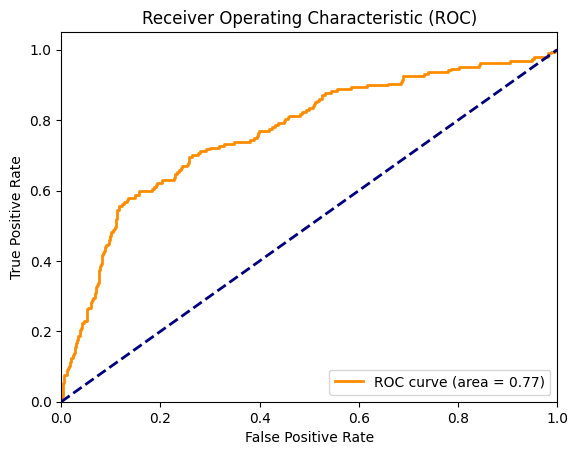

In [54]:
# Import roc_curve
from sklearn.metrics import roc_curve,auc

y_pred_prob = rf.predict_proba(X_test)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

The ROC curve hasn't improved much. This is might be due to class Imbalace. We can do oversampling using SMOTE to see we can improve this.

In [55]:
from imblearn.over_sampling import SMOTE
# Assume X_train and y_train are your data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [56]:
# Import the necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)

# Fit the model to the training data
rf.fit(X_res, y_res)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

# Generate the confusion matrix, classification report, and roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.7775650523922405
[[23514    24]
 [   83   104]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       0.81      0.56      0.66       187

    accuracy                           1.00     23725
   macro avg       0.90      0.78      0.83     23725
weighted avg       1.00      1.00      1.00     23725



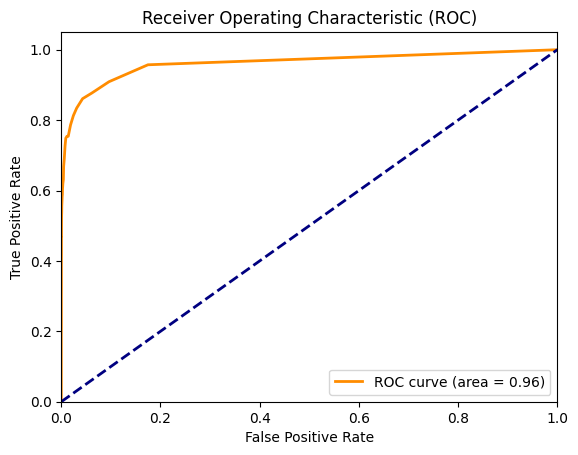

In [57]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc

#Getting the prediction probabilities using the random forest classifier
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Getting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#Getting the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [58]:
print(roc_auc_score(y_test, y_pred))
print(auc(fpr, tpr))

0.7775650523922405
0.9612389205212826


The AOC and the fraud detection has improved significantly due to oversampling. Let's try to do some randomized grid search to see if we can get better hyperparameters to try

In [59]:
from sklearn.model_selection import RandomizedSearchCV
#silence warnings
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


# Define the parameter grid
param_grid = {
    'n_estimators': [30, 50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy']
}

# Initialize a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = RandomizedSearchCV(estimator=rf,cv=5,param_distributions=param_grid, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the resampled data
grid_search.fit(X_res, y_res)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Fit the model to the training data using best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_res, y_res)

# Predict the labels of the test data: y_pred
y_pred = rf_best.predict(X_test)

# Generate the confusion matrix, classification report, and roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}
0.7829763727148682
[[23517    21]
 [   81   106]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       0.83      0.57      0.68       187

    accuracy                           1.00     23725
   macro avg       0.92      0.78      0.84     23725
weighted avg       1.00      1.00      1.00     23725



The model has improved significantly with a recall score of 0.59. 

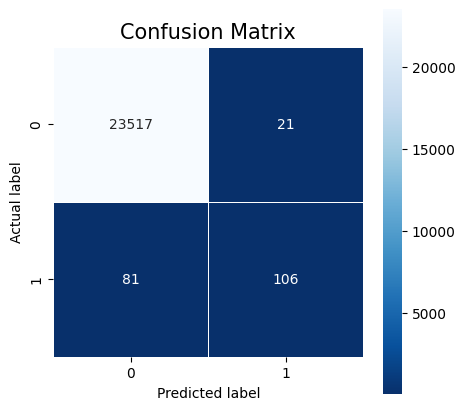

In [75]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()

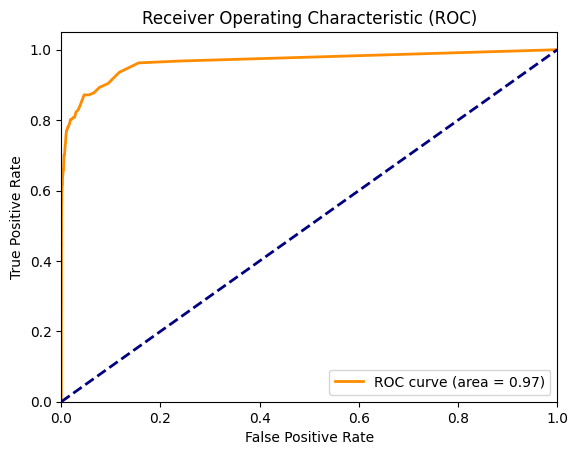

In [61]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc

#Getting the prediction probabilities using the random forest classifier
y_pred_prob = rf_best.predict_proba(X_test)[:,1]

# Getting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#Getting the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [62]:
print(roc_auc_score(y_test, y_pred))
print(auc(fpr, tpr))

0.7829763727148682
0.9655879013251072
